<h1 style="text-align: center;">Optimizing Hotel Revenue: A Machine Learning Approach to Cancellation Prediction</h1>
<h3 style="text-align: center;">By : Melin Ayu Safitri</h3>

---

## **Section 1. Business Understanding**

**1.1 Context**<br>

In the hospitality industry, business success is highly dependent on a hotel’s ability to maximize room occupancy while maintaining operational efficiency. However, one of the biggest challenges faced is the high cancellation rate of reservations. Data shows that many customers make reservations well in advance of their check-in date, but later cancel them due to reasons such as schedule changes.

A hotel wants to prepare rooms for its potential customers. Based on the available records, the hotel aims to identify which customers will actually stay and which ones will cancel their bookings.

Target:

0: Booking not canceled<br>
1: Booking canceled

**1.2 Problem Statements**<br>

Booking cancellations represent a significant challenge that can directly impact revenue, operational planning, and customer satisfaction. By using probabilities from a classification model, hotels can predict the risk of cancellation for each reservation.

Hotels face a several challenges related to cancellations:<br>

- Financial Loss: Last-minute cancellations result in empty rooms that could have been sold to other customers.
- Operational Uncertainty: It is difficult to plan for customer needs, inventory, and other resources when cancellation rates are unpredictable.

**1.3 Goals**<br>

Hotels aim to predict the probability of a booking cancellation so they can focus on mitigating risks associated with cancellations by implementing proactive strategies, such as targeted overbooking or offering last-minute deals for rooms predicted to be unoccupied.  

Hotels also seek to understand the factors that make a booking more likely to be canceled. By identifying these factors, they can develop better strategies to reduce cancellation rates, such as adjusting booking policies, offering flexible options, or tailoring promotions to retain at-risk customers.


**1.4 Analytical Approach**<br>

To address the problem, we will analyze the data to uncover patterns in the features that distinguish canceled bookings from non-canceled ones. By identifying the relationships between these features and the likelihood of cancellations, we aim to gain valuable insights into the key drivers of booking cancellations.  

Next, we will build a classification model to predict the probability of a booking cancellation. This predictive tool will assist hotels in implementing proactive strategies, such as overbooking for high-risk bookings or providing incentives to retain customers. Additionally, it will enable better decision-making by offering a clear understanding of the factors influencing booking cancellations, ensuring hotels minimize revenue loss and optimize their operations.

**1.5 Metric Evaluation (Business Metric, Machine Learning Evaluation Metric)**<br>

- **Business Metric**
    - Revenue Recovery Rate: The percentage of revenue recovered from rooms predicted to be cancelled, through strategies such as overbooking.
    - Relevance: Measures the effectiveness of implementing model predictions in reducing financial losses due to cancellations.

- **Machine Learning Evaluation Metric**
    - False Positive (Type I Error): A reservation is predicted to be canceled but is actually not.
    - False Negative (Type II Error): A reservation is predicted not to be canceled but actually gets canceled.

    - Consequence: Lost revenue due to rooms that remain empty and cannot be rebooked, resulting in financial loss for the hotel.

    Based on the consequences of both types of errors, the hotel aims to reduce the financial loss caused by `false negatives` (cancellations that the model fails to detect), while avoiding unnecessary actions arising from `false positives` (overbooking).

    Appropriate Evaluation Metric: `ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)`

    - Selection Rationale: ROC-AUC measures the model's ability to distinguish between customers who will cancel and those who will not at various probability thresholds.
    - Main Focus: Balancing the False Positive Rate (FPR) and True Positive Rate (TPR) at various thresholds, ensuring that the model performs optimally.


**1.6 Success Criteria**<br>
- ROC-AUC Score Improvement: The model should achieve `ROC-AUC ≥ 0.80` to ensure reliable and dependable predictions across various threshold scenarios.

## **Section 2. Data Understanding**

In [105]:
# import library
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LearningCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

# Feature Engineering
import category_encoders as ce
from category_encoders import BinaryEncoder

# Models and Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Imbalanced Dataset Handling
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Library SciPy
from scipy.stats import shapiro

# Others
import warnings
import pickle

# Configure Settings
warnings.simplefilter("ignore")  # Ignore warnings
pd.set_option('display.max_columns', None) 

**2.1 General Information**


|No | Feature | Data Type | Description|
|---|---------| --------- | -----------|
|1.|country | object | Country of origin|
|2.|market_segment | object | Market segment designation|
|3.|previous_cancellations | int64 | Number of previous bookings that were cancelled by the customer prior to the current booking|
|4.|booking_changes | int64 | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|5.|deposit_type | object | Indication on if the customer made a deposit to guarantee the booking|
|6.|days_in_waiting_list | int64 | Number of days the booking was in the waiting list before it was confirmed to the customer|
|7.|customer_type | object | Type of booking|
|8.|reserved_room_type | object | Code of room type reserved. Code is presented instead of designation for anonymity reasons|
|9.|required_car_parking_space | int64 | Number of car parking spaces required by the customer|
|10.|total_of_special_request | int64 | Number of special requests made by the customer (e.g. twin bed or high floor)|
|11.|is_canceled | int64 | Value indicating if the booking was canceled (1) or not (0)|


**2.2 Feature Information**

|No.| Feature | Impact to Business |
|---|---------| ------------------ |
| 1. | country |Helps in targeting specific geographic markets with tailored marketing strategies, optimizing regional demand.|
| 2. | market_segment |Enables price optimization and cost control by understanding the distribution of bookings across different segments.|
| 3. | previous_cancellations |High cancellation rates could signal a need for better booking policies or incentives to reduce lost revenue.|
| 4. | booking_changes|Frequent changes to bookings can create operational inefficiencies, leading to higher labor costs and potential customer dissatisfaction.|
| 5. | deposit_type |Non-refundable deposits secure revenue and reduce cancellations, while refundable deposits may lead to more flexibility and customer trust.|
| 6. | days_in_waiting_list|Long waiting times can decrease customer satisfaction, leading to potential lost bookings if not addressed.|
| 7. | customer_type|Identifying customer types allows for tailored pricing and booking management strategies.|
| 8. | reserved_room_type|Accurate room type reservations ensure customer satisfaction and prevent issues with overbooking or mismatch between expectations and actual offerings.|
| 9. | required_car_parking_space|Understanding parking demand ensures sufficient availability for guests, preventing dissatisfaction from inadequate facilities.|
| 10.| total_of_special_request|Managing special requests enhances guest satisfaction but may increase operational complexity and costs.|
| 11.| is_canceled|Tracking cancellations allows for better revenue forecasting and aids in adjusting booking policies to minimize revenue loss.|


**2.3 Statistics Summary**

In [106]:
df = pd.read_csv(r'C:\Users\user\OneDrive\Documents\Hotel-Booking-Demand-Project\data\raw\data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


**Dataset Overview:**<br>
- **Total Entries**: `83,573 rows`
- **Missing Values**: Only in `country` (351 missing values).

In [108]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


**Insight:**<br>
- **Median (50%): 0** → More than **50% of customers have never canceled a reservation before**.  
- **Max: 21** → Some customers made **up to 21 changes to their reservation**.  
- **Max: 391** → Some customers waited **up to 391 days for confirmation** (significant outlier).  
- **Mean: 0.06** → The **majority of customers do not require parking spaces**.  
- **Most customers do not have special requests**, but some may have specific preferences.  
- The **cancellation rate is quite significant (37%)**, requiring further analysis to identify the factors contributing to cancellations.  

In [109]:
df.describe(include='object')

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


**Insight:**<br>
- The **majority of customers are from Portugal**, indicating that the **domestic market dominates hotel reservations**.  
- The **Online Travel Agency (OTA) market segment is the primary channel for hotel reservations**, highlighting the **importance of online platforms for the hotel's business**.  
- **Freq: 73,352 → Approximately 88% of customers do not provide a deposit upfront**.  
- **Freq: 62,732 → Around 75% of customers are of the Transient type** (individual customers with short-term reservations).  

## **Section 3. Data Cleaning**

Objectives:<br>
- Ensure clean and consistent datasets to improve model accuracy.
- Reduce errors caused by invalid or irrelevant data.
- Improve the efficiency of the model training and prediction process.

**3.1 Missing Values**

In [110]:
# Data Cleaning - Identify Missing Values
df.isnull().sum().apply(lambda x: f'{x} = ({x/len(df):.2%})')

country                        351 = (0.42%)
market_segment                   0 = (0.00%)
previous_cancellations           0 = (0.00%)
booking_changes                  0 = (0.00%)
deposit_type                     0 = (0.00%)
days_in_waiting_list             0 = (0.00%)
customer_type                    0 = (0.00%)
reserved_room_type               0 = (0.00%)
required_car_parking_spaces      0 = (0.00%)
total_of_special_requests        0 = (0.00%)
is_canceled                      0 = (0.00%)
dtype: object

**Insight:**<br>

The country column has 351 missing values, representing approximately 0.42% of the data.<br>
This is a relatively small percentage and can be addressed using methods to removing the rows.

In [111]:
# Handling Missing Values
df = df.dropna()

In [112]:
# Confirm the adjustments by checking for any remaining missing values.
df[["country"]].isna().sum().reset_index().rename(columns={"index": "column", 0: "missing values"})

,column,missing values
0,country,0


***The missing values has been successfully addressed***

**3.2 Duplicated Values**

In [113]:
# Data Cleaning - Identify Data Duplicated
print('Total Duplicated Rows: ', df.duplicated().sum())

Total Duplicated Rows:  73138


In [114]:
df[df.duplicated()]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
22,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
29,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
34,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
44,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [115]:
df[(df['country'] == 'PRT') & (df['customer_type'] == 'Contract') & (df['deposit_type'] == 'No Deposit') & (df['market_segment'] == 'Groups')]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
151,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
189,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
2450,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
3060,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
3626,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
80541,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
82066,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
82790,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1
83099,PRT,Groups,1,0,No Deposit,0,Contract,A,0,0,1


**Insight:**<br>

It can be seen that the description of each column above proves that the data values are truly duplicates across all columns, and therefore, it requires handling. This is because duplicate data causes redundancy, which does not add any value to the analysis, and machine learning models can become biased if the same data is repeated multiple times.

In [116]:
# Handling Data Duplicated
df.drop_duplicates(inplace=True)

In [117]:
# Verifying duplicates, since each listing should have a distinct identifier
df.duplicated().sum()

np.int64(0)

***I have verified that the dataset contains no duplicate entries.***

**3.3 Identify Spelling Errors**

In [118]:
# Categoric Variable

categoric_features = df.select_dtypes('object')

for col in categoric_features.columns:
    print(f"Total category on '{col}': {df[col].nunique()}")

Total category on 'country': 162
Total category on 'market_segment': 8
Total category on 'deposit_type': 3
Total category on 'customer_type': 4
Total category on 'reserved_room_type': 10


In [119]:
for col in categoric_features.columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print()

Column: country
country
PRT    1993
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
DMA       1
KIR       1
MYT       1
KNA       1
AIA       1
Name: count, Length: 162, dtype: int64

Column: market_segment
market_segment
Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Undefined           1
Name: count, dtype: int64

Column: deposit_type
deposit_type
No Deposit    9843
Non Refund     194
Refundable      47
Name: count, dtype: int64

Column: customer_type
customer_type
Transient          6813
Transient-Party    2549
Contract            481
Group               241
Name: count, dtype: int64

Column: reserved_room_type
reserved_room_type
A    4562
D    2025
E    1248
F     715
G     546
B     454
C     339
H     192
L       2
P       1
Name: count, dtype: int64



The fact that **no spelling errors were found** indicates that the dataset is well-maintained, with clean and reliable text entries.

**3.4 Identify Anomaly Values**

- Check Distribution (Numerical Variable)

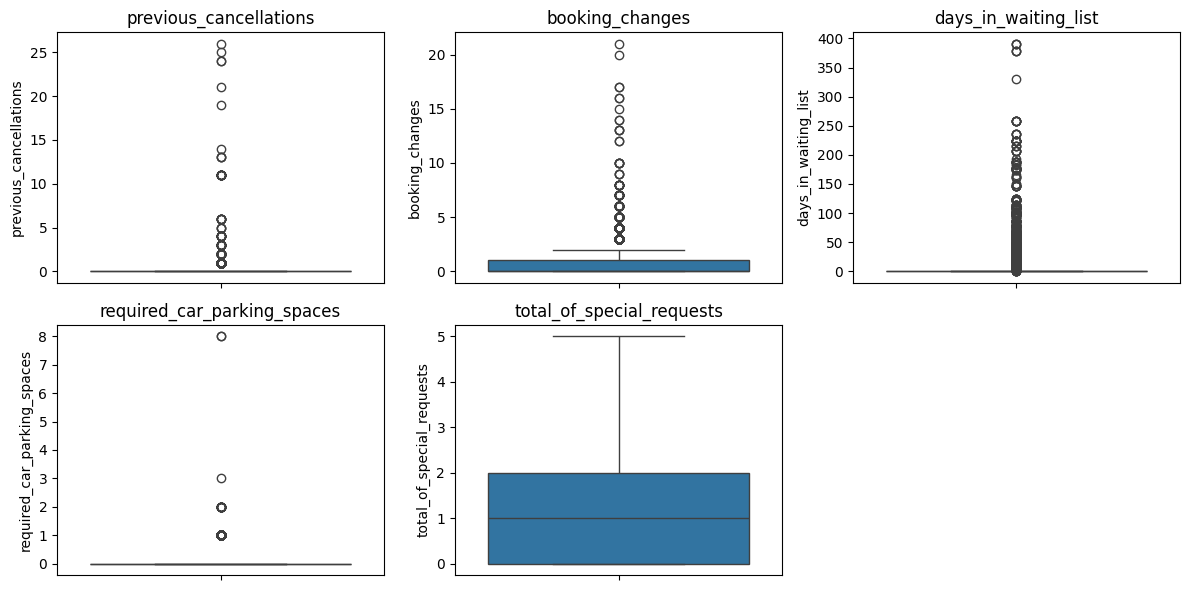

In [120]:
# Identify Numeric Distribution
num_features=df.drop(['country','market_segment','deposit_type','customer_type',
                      'reserved_room_type', 'is_canceled'],axis=1)

plt.figure(figsize=(12,6))
for idx,feature in enumerate(num_features.columns, start=1):
    sns.boxplot(df[feature], ax=plt.subplot(2,3,idx))
    plt.subplot(2,3,idx).set_title(feature)
plt.tight_layout()
plt.show()

**Insight:**<br>

From the descriptive statistics previously performed, there are extreme outliers in the **`days_in_waiting_list`** variable. In the context of hotel reservations or similar services, waiting for more than **300 days** for confirmation is highly unrealistic and can lead to distortions in statistical analysis and model outcomes.

To address this issue, we will remove these outlier data points. This is because machine learning models can become **biased** if very rare or unrealistic data points are left in the dataset. This can lead to **overfitting**, where the model becomes overly focused on cases that do not represent the majority of the data and performs poorly on other data.

- Handling Anomaly Values

In [121]:
(df['days_in_waiting_list'] >= 300).sum()

np.int64(7)

7 outliers from 10,084 rows represent approximately 0.07% of the total data.

In [122]:
# So, drop rows where the value of `days_in_waiting_list` is greater than 300
df = df.drop(df[df['days_in_waiting_list'] > 300].index)


In [123]:
(df['days_in_waiting_list'] >= 300).sum()

np.int64(0)

***The outlier data has been successfully removed.***

- Check Cardinality (Categorical Variable)

In [124]:
# Identify Categorical Distribution
cat_features=df[['country','market_segment','deposit_type','customer_type',
                 'reserved_room_type']]

for feature in cat_features.columns:
    print (f'total unique values({feature}): {df[feature].nunique()}')
    print(df[feature].value_counts(normalize=True))
    print("")

total unique values(country): 162
country
PRT    0.197380
GBR    0.072839
ESP    0.063610
FRA    0.060435
DEU    0.042870
         ...   
DMA    0.000099
KIR    0.000099
MYT    0.000099
KNA    0.000099
AIA    0.000099
Name: proportion, Length: 162, dtype: float64

total unique values(market_segment): 8
market_segment
Online TA        0.488637
Direct           0.206311
Offline TA/TO    0.145778
Groups           0.083160
Corporate        0.050114
Complementary    0.017862
Aviation         0.008038
Undefined        0.000099
Name: proportion, dtype: float64

total unique values(deposit_type): 3
deposit_type
No Deposit    0.976382
Non Refund    0.018954
Refundable    0.004664
Name: proportion, dtype: float64

total unique values(customer_type): 4
customer_type
Transient          0.675796
Transient-Party    0.252555
Contract           0.047732
Group              0.023916
Name: proportion, dtype: float64

total unique values(reserved_room_type): 10
reserved_room_type
A    0.452019
D    0.2009

In [125]:
# Data Cleaning - Identify Target Distribution
df['is_canceled'].value_counts().apply(lambda x: f'{x} = {(x/len(df)):.1%}')

is_canceled
0    7685 = 76.3%
1    2392 = 23.7%
Name: count, dtype: object

**Insight :** <br>

This data is considered **imbalanced** because the distribution of the **`is_canceled`** variable is not even. The majority of the data (76.3%) represents **non-canceled reservations (0)**, while only 23.7% represents **canceled reservations (1)**.

Since the number of data points in class **`0`** is much higher, the model is likely to predict class **`0`** more often, which can lead to **bias** and **poor performance** in predicting class **`1`**. This makes the model less effective at handling cases where the minority class (cancellations) is more important.

In [126]:
df.to_csv('clean_dataset.csv')

## **Section 4. Data Generation**

This process is important to ensure that the model is trained with data that is representative, diverse, and covers all possible real-world scenarios.

Objectives:<br>
- Building Generalizable Models: Helping models learn from existing data and apply that knowledge to previously unseen data.
- Ensuring Accurate Evaluation: Providing enough data to objectively test model performance using unseen data.
- Improving Model Performance: With data augmentation techniques or synthetic data generation, models can be trained better, even with limited data.

**4.1 Constructing `Seen` and `Unseen` Data**

**Seen Data** refers to the data that the model sees during training. The model uses this data to learn the patterns and relationships between features and the target. Typically, the training data consists of 80-90% of the total dataset.<br>

**Unseen Data** refers to the data that the model has never encountered during training and is used during testing. Unseen data is crucial for measuring how well the model generalizes the patterns it learned to new, previously unseen data. This data is used for final evaluation and typically accounts for 10-20% of the total dataset.

In [127]:
# Define feature and target
feature_seen = df.drop('is_canceled', axis=1)
target_seen = df['is_canceled']

**4.2 Constructing `Training` and `Testing` Data (from `Seen` Dataset)**

**Why 80:20 Split?** This ratio aligns with Pareto's Law (80/20 rule), where 80% of the effects come from 20% of the causes. In this case, 80% of the data is used for training the model, and 20% is kept aside for testing. The 20% testing data is often sufficient to get a reliable estimate of the model's performance without compromising training data size.

In [128]:
# Split data into Seen (80%) and Unseen (20%)
df_seen, df_unseen = train_test_split(df, test_size=0.2, random_state=42, stratify= target_seen) 

In [129]:
# Check the shape of each dataset
print("Shape of seen dataset:", df_seen.shape)
print("Shape of unseen dataset:", df_unseen.shape)

Shape of seen dataset: (8061, 11)
Shape of unseen dataset: (2016, 11)


## **Section 5. Exploratory Data Analysis (EDA)**

**5.1 Check Correlation**

In [130]:
df_seen.corr(numeric_only=True)

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
previous_cancellations,1.000000,-0.045691,-0.008174,-0.018970,-0.012111,0.068511
booking_changes,-0.045691,1.000000,-0.027156,-0.009095,-0.007807,-0.069715
days_in_waiting_list,-0.008174,-0.027156,1.000000,-0.053255,-0.124549,0.024936
required_car_parking_spaces,-0.018970,-0.009095,-0.053255,1.000000,0.029895,-0.235913
total_of_special_requests,-0.012111,-0.007807,-0.124549,0.029895,1.000000,-0.070752
is_canceled,0.068511,-0.069715,0.024936,-0.235913,-0.070752,1.000000


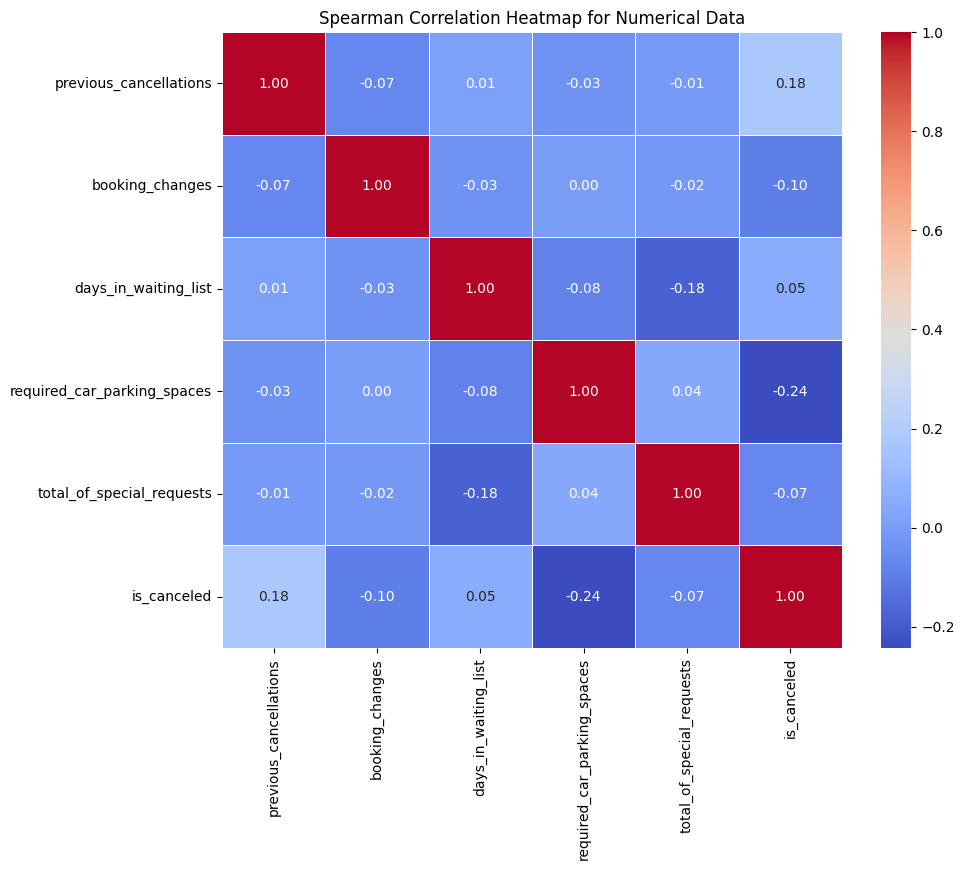

In [131]:
# Filter for numerical columns
numerical_data = df_seen.select_dtypes(include=['number'])

# Calculate the Spearman correlation matrix
correlation_matrix = numerical_data.corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Heatmap for Numerical Data')
plt.show()

**Insight:**<br>

Previous Cancellations and Is Canceled: A moderate positive correlation (0.18) is observed.<br>
This suggests that guests with a history of cancellations are more likely to cancel future bookings.

**5.2 Barplot**

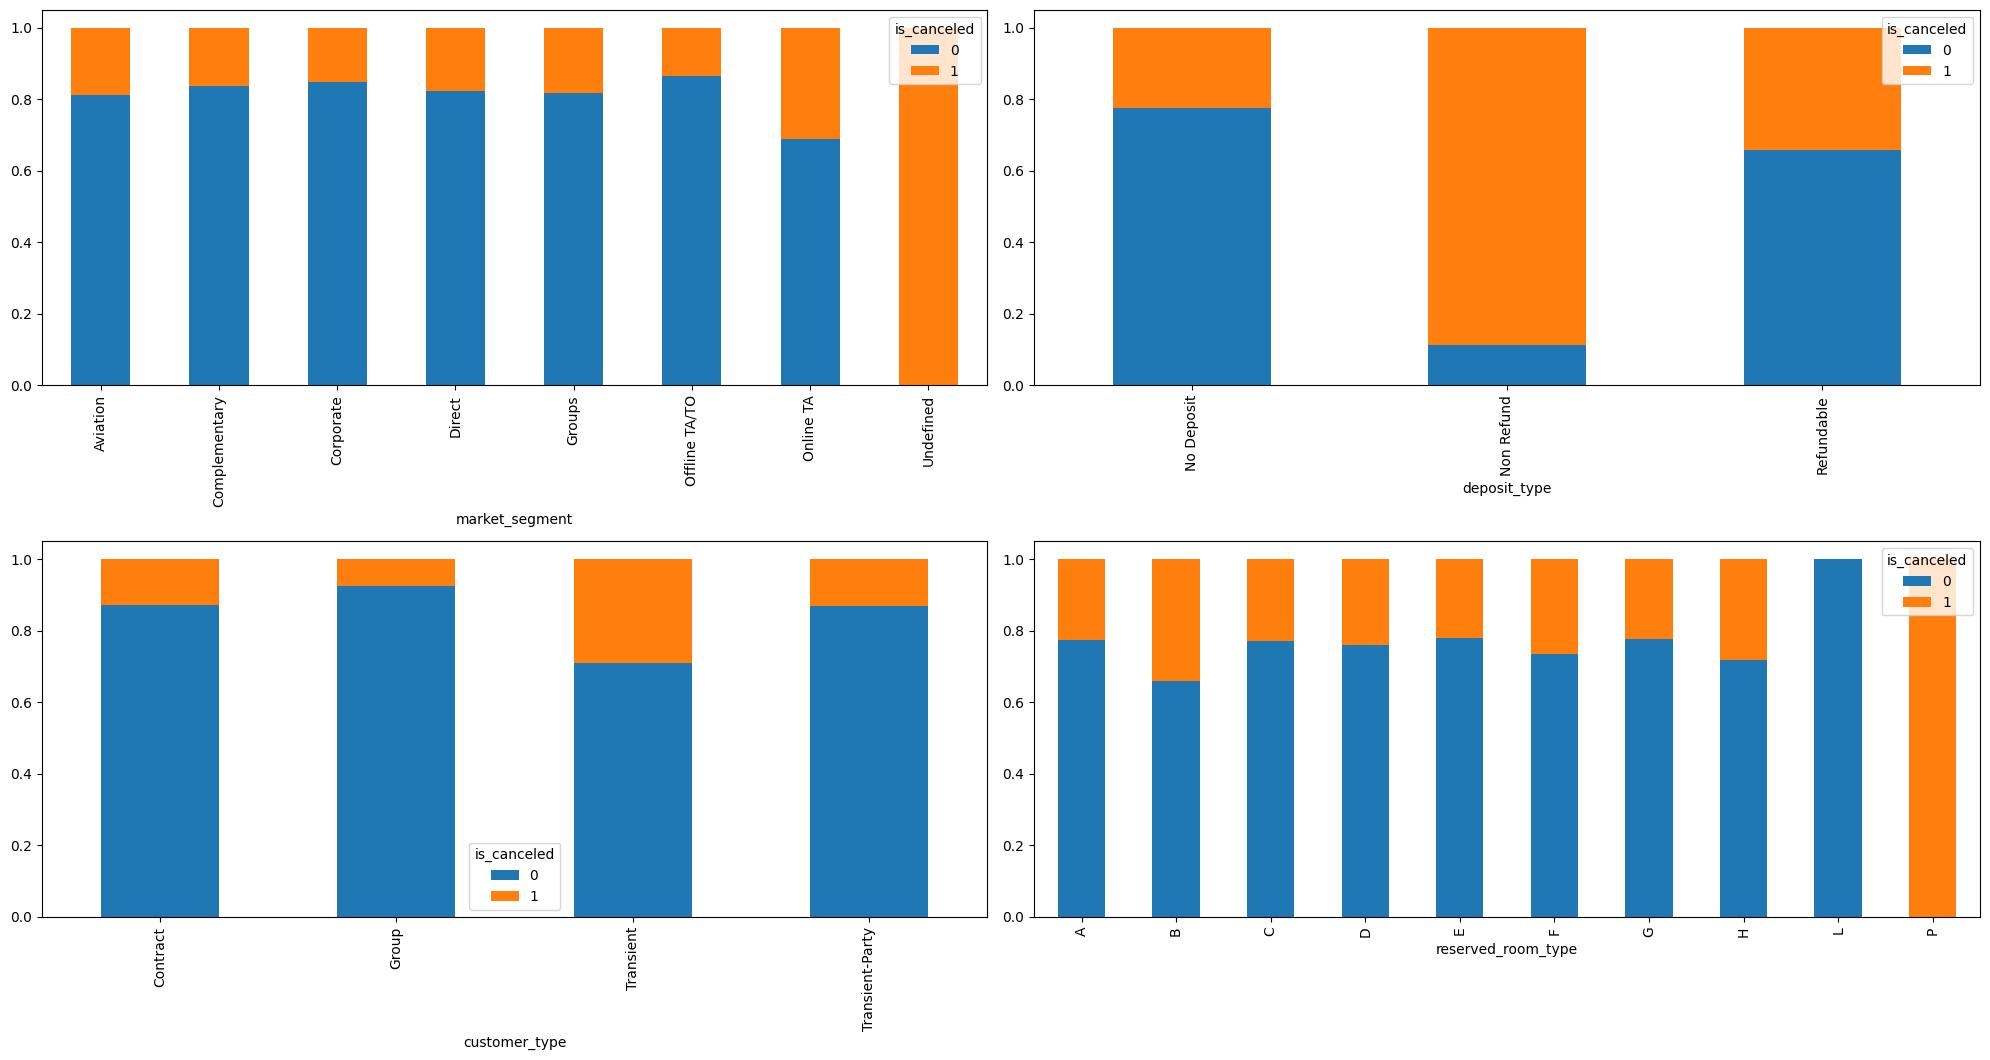

In [132]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df_seen.drop(columns=['is_canceled','country','previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df_seen[i],df_seen['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

**Based on visualization above, it can be concluded that:** 

- There is a relationship between certain variables and the cancellation rate. Some market segments, deposit types, customer types, and room types have higher cancellation rates compared to others.  
- This information can be used to identify areas that need improvement. For example, hotels can focus on customer retention strategies for segments with high cancellation rates or adjust deposit policies to reduce cancellations.

In [133]:
for i in df_seen.drop(columns=['is_canceled','country','previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']).columns:
    market_segment_df = df_seen.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    display(market_segment_df.sort_values(by=[1.0], ascending=False))

is_canceled,0,1
market_segment,,
Undefined,NaN,1.000000
Online TA,0.687011,0.312989
Aviation,0.811594,0.188406
Groups,0.816265,0.183735
Direct,0.821668,0.178332
Complementary,0.836879,0.163121
Corporate,0.846914,0.153086
Offline TA/TO,0.865303,0.134697


is_canceled,0,1
deposit_type,,
Non Refund,0.111842,0.888158
Refundable,0.657895,0.342105
No Deposit,0.775759,0.224241


is_canceled,0,1
customer_type,,
Transient,0.709392,0.290608
Transient-Party,0.868008,0.131992
Contract,0.870558,0.129442
Group,0.924623,0.075377


is_canceled,0,1
reserved_room_type,,
P,NaN,1.000000
B,0.659574,0.340426
H,0.717105,0.282895
F,0.735294,0.264706
D,0.759293,0.240707
C,0.771863,0.228137
A,0.774469,0.225531
G,0.775982,0.224018
E,0.779575,0.220425


**Insight :**<br>

- ***Market Segment:*** OTA and Undefined market segments have high cancellation rates.
- ***Deposit Type:*** Non-refundable deposits have a higher chance of cancellations.
- ***Customer Type:*** Transient customers are more prone to cancel.
- ***Reserved Room Type:*** Room types L and P have disproportionately higher cancellation rates.

Text(0.5, 0, 'Is Canceled Status')

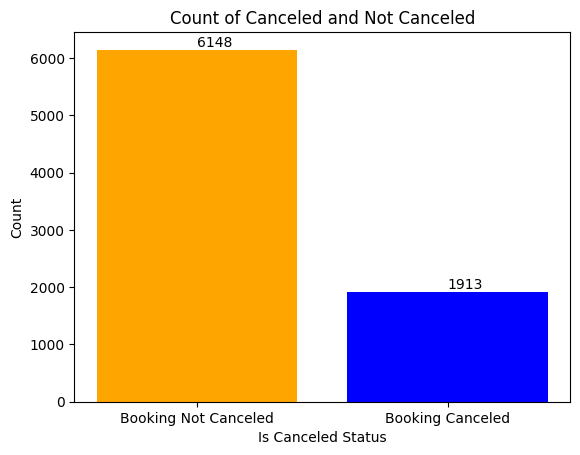

In [134]:
# Updated categories and counts
categories = ['Booking Not Canceled', 'Booking Canceled']
counts = df_seen['is_canceled'].value_counts()

# Generating the updated bar chart
fig, ax = plt.subplots()
bars = ax.bar(categories, counts, color=['orange', 'blue'])

# Adding the count above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  

# Setting the title and labels
ax.set_title('Count of Canceled and Not Canceled')
ax.set_ylabel('Count')
ax.set_xlabel('Is Canceled Status')

**Insight:**

- ***High Retention Rate:*** The significantly higher count of `Booking Not Canceled` suggests a relatively high retention rate for bookings. This could indicate that the hotel is doing a good job in retaining guests and minimizing cancellations.

- ***Potential for Improvement:*** While the retention rate is high, there is still a considerable number of cancellations. Analyzing the factors contributing to these cancellations (as shown in the visualization) could help identify areas for improvement in booking policies, customer service, or other aspects of the hotel's operations.

**5.3 Normality Test**

In [135]:
numerical_columns = df_seen.select_dtypes(include=["int64", "float64"]).columns

normality_test_results = {}

num_cols = len(numerical_columns)

rows = (num_cols + 2) // 3

for i, col in enumerate(numerical_columns):

    # Perform the Shapiro-Wilk Test for normality
    shapiro_test = shapiro(df_seen[col])  # Use shapiro directly

    # Calculate the skewness
    skewness = df[col].skew()

    # Determine the skew direction
    if skewness > 0:
        skew_direction = "Positive"
    elif skewness < 0:
        skew_direction = "Negative"
    else:
        skew_direction = "None"

    # Storing the results
    normality_test_results[col] = {
        "Shapiro-Wilk Statistic": shapiro_test.statistic,
        "Shapiro-Wilk p-value": shapiro_test.pvalue,
        "Skewness": skewness,
        "Skew Direction": skew_direction
    }

# Convert the dictionary to a DataFrame
normality_results_df = pd.DataFrame(normality_test_results).T

# Adding a column to indicate if the data is normally distributed based on p-values
normality_results_df["Normally Distributed"] = (normality_results_df["Shapiro-Wilk p-value"] > 0.05)

normality_results_df

,Shapiro-Wilk Statistic,Shapiro-Wilk p-value,Skewness,Skew Direction,Normally Distributed
previous_cancellations,0.08674,0.0,18.849286,Positive,False
booking_changes,0.629617,0.0,3.745516,Positive,False
days_in_waiting_list,0.157677,0.0,7.84598,Positive,False
required_car_parking_spaces,0.434923,0.0,3.302156,Positive,False
total_of_special_requests,0.817682,0.0,0.981649,Positive,False
is_canceled,0.527404,0.0,1.234707,Positive,False


## **Section 6. Data Preparation**

**6.1 Initialization**

- Define Feature and Target

In [136]:
# define feature and target

feature = df_seen.drop('is_canceled', axis=1)
target = df_seen['is_canceled']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2,
                                                    random_state=42, stratify=target)
print(X_train.shape)
print(y_train.shape)

(6448, 10)
(6448,)


In [138]:
df_seen.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
29711,CN,Online TA,0,0,No Deposit,0,Transient,F,0,2,0
52006,GBR,Groups,0,1,No Deposit,113,Transient-Party,A,0,0,0
32784,ESP,Online TA,0,0,No Deposit,0,Transient,F,0,2,0
54581,PRT,Corporate,1,1,No Deposit,0,Transient,A,0,0,0
150,POL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


By adjusting the skewness values during the EDA phase, we can determine whether numerical columns should undergo **Binning** or **Scaling**. Here’s what we will do:

1. Perform **Binning** on the `previous cancellations` column, where **0** indicates no previous cancellations and **1** indicates previous cancellations. This is because the skewness value of this column is extremely high at **18.8**, indicating a highly positive skew, making it unsuitable for **Scaling**.  

2. Perform **Binning** on the `booking changes` column, where **0** indicates no booking changes and **1** indicates booking changes. The skewness value is also highly positive at **3.7**, making it unsuitable for **Scaling**.  

3. Perform **Binning** on the `days in waiting list` column, where **0** indicates not on the waiting list and **1** indicates being on the waiting list. This column also shows a highly positive skew with a value of **7.8**.  

4. Perform **Binning** on the `required_car_parking_spaces` column, where **0** indicates no parking space requested and **1** indicates parking space requested. The skewness value here is **3.3**, indicating a highly positive skew, and there are extreme outliers in this column, making it unsuitable for **Scaling**.  

5. Perform **Scaling** on the `total_of_special_requests` column because it shows only a slight skewness of **0.9** and does not contain extreme outliers in its values. Using **MinMax Scaling** because the values haven't been extreme outliers.

Now let’s perform **feature encoding** for the categorical features we have. Here’s what we’ll do:

1. **Transform the `country` column using Binary Encoding:**  
   The `country` column contains many unique values and has no inherent order (it’s not ordinal). If we use **One-Hot Encoding**, it will create too many new features, and using **Ordinal/Label Encoding** might not produce meaningful results. Therefore, **Binary Encoding** is a more suitable choice to efficiently represent this feature without introducing unnecessary complexity.

2. **Transform the `market_segment` column using One-Hot Encoding:**  
   This column contains different market segment types (e.g., Corporate, Direct, Online, etc.). These segment types do not have any clear order or numerical relationship, making **One-Hot Encoding** the most appropriate choice. Each segment will be converted into a binary dummy variable that can be processed by machine learning models without implying any incorrect ordinal meaning.

3. **Transform the `deposit_type` column using One-Hot Encoding:**  
   The `deposit_type` column contains information about deposit types (e.g., No Deposit, Non-Refund, and Refundable). Although there are only three categories, there is no numerical order between them. **One-Hot Encoding** is the better choice because it accurately represents each deposit type without introducing a misleading ordinal relationship.

4. **Transform the `customer_type` column using One-Hot Encoding:**  
   This column indicates customer types (e.g., Transient, Contract, Group). Similar to `market_segment`, it has no inherent order or numerical meaning. Therefore, **One-Hot Encoding** is the appropriate choice, allowing each customer type to be represented without suggesting any ordinal or numerical relationship.

5. **Transform the `reserved_room_type` column using One-Hot Encoding:**  
   This column represents the type of room reserved (e.g., A, B, C, etc.). Since these categories have no clear numerical order and each room type has a distinct meaning, **One-Hot Encoding** will convert each room type into a binary column, ensuring that the model does not assume any ordinal relationship between them.

**6.2 Data Transformation (Feature Engineering)**

In [139]:
# binning
df_seen['previous_cancellations'] = df_seen['previous_cancellations'].apply(lambda x: 0 if x == 0 else 1)
df_seen['booking_changes'] = df_seen['booking_changes'].apply(lambda x: 0 if x == 0 else 1)
df_seen['days_in_waiting_list'] = df_seen['days_in_waiting_list'].apply(lambda x: 0 if x == 0 else 1)
df_seen['required_car_parking_spaces'] = df_seen['required_car_parking_spaces'].apply(lambda x: 0 if x == 0 else 1)

# Create transformer object
transformer = ColumnTransformer(
    transformers=[
        ('scaling_minmax', MinMaxScaler(), ['total_of_special_requests']),
        ('encoding_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
        ('binary', ce.BinaryEncoder(), ['country'])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

**6.3 Overview**

In [140]:
# transformer 
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling_minmax', MinMaxScaler(),
                                 ['total_of_special_requests']),
                                ('encoding_ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type']),
                                ('binary', BinaryEncoder(), ['country'])],
                  verbose_feature_names_out=False)

In [141]:
X_train_pre = transformer.transform(X_train)
X_test_pre = transformer.transform(X_test)

# DataFrame
X_train_pre = pd.DataFrame(X_train_pre, columns=transformer.get_feature_names_out())
X_test_pre = pd.DataFrame(X_test_pre, columns=transformer.get_feature_names_out())

In [142]:
X_train_pre

,total_of_special_requests,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces
0,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,75.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
6444,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6445,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,96.0,0.0
6446,0.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## **Section 7. Model Development**

**7.1 Initialization**

- Create a workflow of the experiment

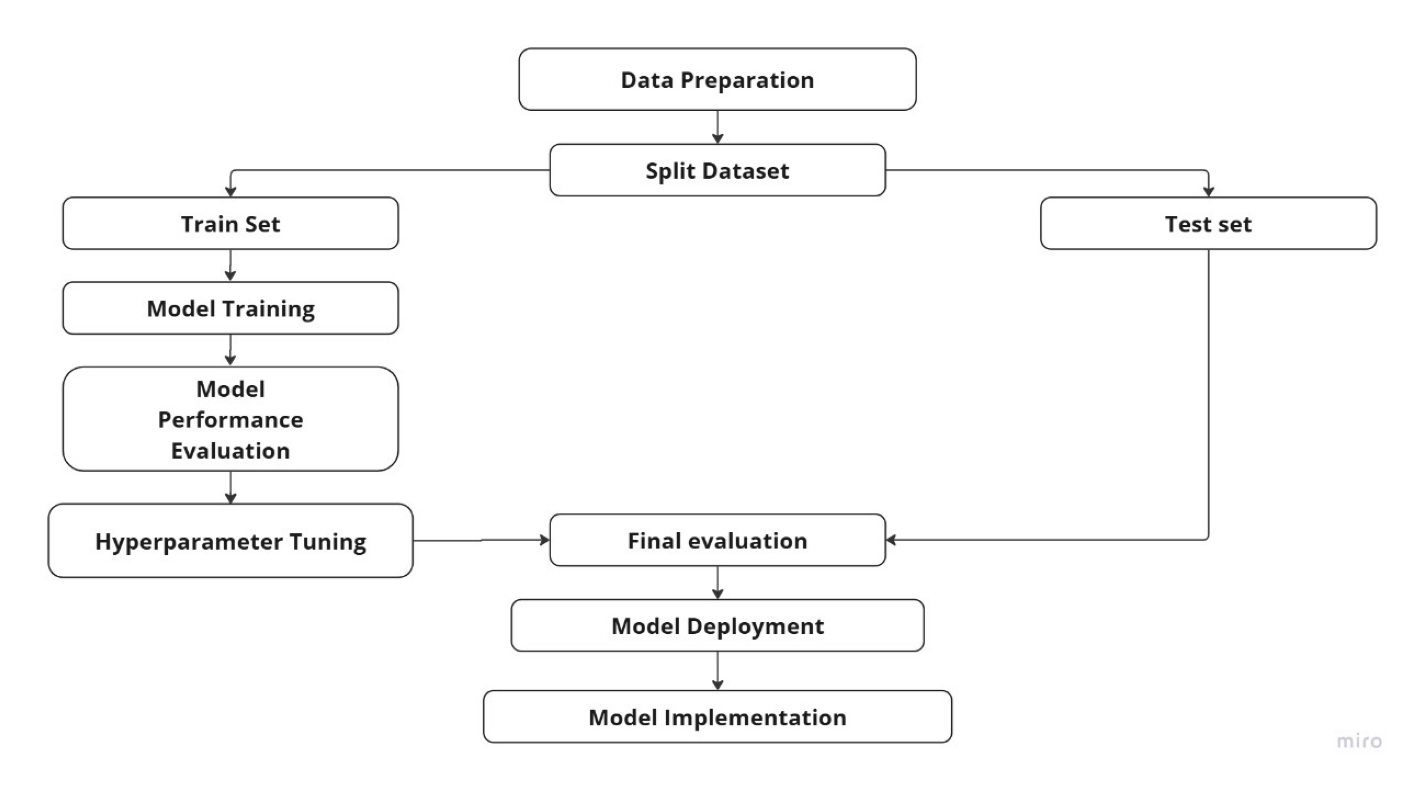

In [143]:
# Load and display an image
plt.figure(figsize=(20, 10))
img = mpimg.imread(r'C:\Users\user\OneDrive\Documents\Hotel-Booking-Demand-Project\assets\Flowchart.jpg')
plt.imshow(img)
plt.axis('off')  
plt.show()

**7.2 Developing the Model Pipeline**

In [144]:
# Create base pipeline

base_clf = Pipeline(steps=[
    ('FeatureEngineering', transformer),
    ('Classifier', None)
])

base_bal_clf = Pipeline(steps=[
    ('FeatureEngineering', transformer),
    ('Resampling', None),
    ('Classifier', None)
])

In [145]:
# Create List Model

logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
svm = SVC(class_weight='balanced', random_state=42)

list_model = [logreg, knn, dt, rf, xgb, lgbm, gbc, ada, svm]

The reasons for selecting the listed models for machine learning, especially considering different approaches to handle class imbalance:<br>

1. **LogisticRegression (logreg)**
   - **Reason for selection**: The model provides a reference point to compare the performance of more complex models. It’s useful to understand how well the model can perform without additional techniques for handling class imbalance.

2. **KNeighborsClassifier (knn)**
   - **Reason for selection**: KNN is chosen as a baseline for performance comparison. Although it can struggle with high-dimensional data, it’s valuable for simpler tasks and provides a good starting point to see how non-parametric models perform on the data.

3. **DecisionTreeClassifier (dt)**
   - **Reason for selection**: Decision Trees are easy to understand and interpret. They help capture non-linear relationships and can be used to visualize hierarchical decision-making.

4. **RandomForestClassifier (rf)**
   - **Reason for selection**: Random Forest is a robust ensemble model that reduces the risk of overfitting seen in single decision trees. By using the `class_weight='balanced'` parameter, Random Forest can give more weight to the minority class, helping to handle class imbalance effectively during tree construction.

5. **XGBClassifier (xgb)**
   - **Reason for selection**: XGBoost is a powerful gradient boosting algorithm that excels in handling imbalanced data. XGBoost is known for its speed and performance, making it a solid choice for classification tasks.

6. **LGBMClassifier (lgb)**
   - **Reason for selection**: LightGBM is another gradient boosting method  to handle class imbalance. It is faster and more memory-efficient than XGBoost, making it a good choice for large datasets. LightGBM tends to perform better on datasets with many categorical features.

7. **GradientBoostingClassifier (gbc)**
   - **Reason for selection**: GradientBoostingClassifier uses a boosting technique based on gradients to build an ensemble of weak learners. GBC useful baseline for gradient boosting and provides a strong comparison to other boosting algorithms like AdaBoost.

8. **AdaBoostClassifier (ada)**
   - **Reason for selection**: AdaBoost useful for handling imbalanced data because it assigns more weight to misclassified instances (which are typically from the minority class), making the model focus more on these harder-to-classify cases.

9. **Support Vector Classifier (svm)**
   - **Reason for selection**: The Support Vector Classifier (SVC) helps handle class imbalance by assigning higher weights to the minority class. SVMs work well in high-dimensional spaces and are effective for separating classes in complex decision boundaries, making them a good choice for imbalanced datasets.

**7.3 Model Benchmarking (Comparing model base performance)**

- **GridSearchCV** is used in this benchmark to find the best models and ensure optimal performance.
- **Cross-validation** using `StratifiedKFold` helps ensure that the model is evaluated on different splits of the data, preventing overfitting and ensuring robustness across various subsets of the dataset.

In [146]:
# without resample

benchmark = GridSearchCV(
    estimator=base_clf,
    param_grid={'Classifier': list_model},
    scoring=['precision', 'recall', 'roc_auc'],
    refit='roc_auc', 
    cv=StratifiedKFold(shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1
)

In [147]:
# benchmark process
benchmark.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 1224, number of negative: 3934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 5158, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237301 -> initscore=-1.167533
[LightGBM] [Info] Start training from score -1.167533
[LightGBM] [Info] Number of positive: 1224, number of negative: 3934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...),
                                        LGBMClassifier(random_state=42),
                                        GradientBoostingClassifier(random_state=42),
                                        AdaBoostClassifier(random_state=42),
                                        SVC(class_weight='balanced',
                                            random_state=42)]},
             refit='roc_auc', return_train_score=True,
             scoring=['precision', 'recall', 'roc_auc'], verbose=1)

The GradientBoostingClassifier (GBC) has emerged as the best-performing model in this benchmarking process. 

**What is Gradient Boosting Classifier?**<br>

Gradient Boosting Classifier (GBC) is a powerful machine learning model widely used for classification tasks, particularly when dealing with complex datasets and non-linear relationships. 

- GBC is an ensemble learning method, meaning it combines multiple individual models (weak learners) to create a stronger overall model.
- In GBC, the weak learners are typically decision trees, where each tree is trained to correct the errors of the previous one.

- Boosting works by assigning more weight to misclassified instances from the previous model. Thus, the model focuses on the harder-to-classify samples, improving performance iteratively.
- The model is typically trained by minimizing a loss function, such as log-loss or deviance (in case of classification), to improve accuracy at each step.

In [148]:
benchmark.best_score_

np.float64(0.8289363129441538)

In [149]:
pd.DataFrame(benchmark.cv_results_).T

,0,1,2,3,4,5,6,7,8
mean_fit_time,0.064804,0.035611,0.042841,0.532604,0.112619,0.114654,0.548999,0.240993,1.457827
std_fit_time,0.008596,0.006988,0.013311,0.021269,0.013497,0.008228,0.030233,0.021878,0.875486
mean_score_time,0.020801,0.079901,0.025171,0.068257,0.034466,0.037664,0.028193,0.046239,1.220775
std_score_time,0.001497,0.017435,0.006982,0.004375,0.001001,0.001982,0.003602,0.005136,0.450178
param_Classifier,LogisticRegression(random_state=42),KNeighborsClassifier(),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42),"XGBClassifier(base_score=None, booster=None, c...",LGBMClassifier(random_state=42),GradientBoostingClassifier(random_state=42),AdaBoostClassifier(random_state=42),"SVC(class_weight='balanced', random_state=42)"
params,{'Classifier': LogisticRegression(random_state...,{'Classifier': KNeighborsClassifier()},{'Classifier': DecisionTreeClassifier(random_s...,{'Classifier': RandomForestClassifier(random_s...,"{'Classifier': XGBClassifier(base_score=None, ...",{'Classifier': LGBMClassifier(random_state=42)},{'Classifier': GradientBoostingClassifier(rand...,{'Classifier': AdaBoostClassifier(random_state...,"{'Classifier': SVC(class_weight='balanced', ra..."
split0_test_precision,0.553571,0.44856,0.355072,0.389105,0.590476,0.57971,0.656716,0.589189,0.380544
split1_test_precision,0.606838,0.399142,0.321799,0.378182,0.51073,0.519417,0.671533,0.651007,0.375723
split2_test_precision,0.616071,0.395062,0.318182,0.338182,0.515837,0.547264,0.726415,0.604651,0.362869
split3_test_precision,0.536585,0.35122,0.292135,0.342105,0.538922,0.60241,0.601852,0.578947,0.376453


In [150]:
# with resample

benchmark_resample = GridSearchCV(
    estimator=base_bal_clf,
    param_grid={'Resampling' : [SMOTE(random_state=42), 
                              RandomOverSampler(random_state=42),
                              RandomUnderSampler(random_state=42),
                              NearMiss(version=1)],
                'Classifier': list_model},
    scoring = ['precision', 'recall', 'roc_auc'],
    refit='roc_auc',
    cv=StratifiedKFold(shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

Here’s why each method is selected:<br>

1. **SMOTE (Synthetic Minority Over-sampling Technique)**: This technique is highly effective when the minority class has limited data, improving model performance by providing more diverse examples for learning.

2. **RandomOverSampler**: This technique increases the number of minority class samples by duplicating instances from the minority class. It is simple but effective in balancing the class distribution, especially in cases where generating synthetic samples may not be preferred.

3. **RandomUnderSampler**: This method reduces the number of majority class samples by randomly removing instances. 

4. **NearMiss**: undersampling technique that selects samples from the majority class that are closest to the minority class. This ensures that the classifier focuses on the most informative majority class examples, helping to improve the model's decision boundary.

In [151]:
benchmark_resample.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                        LGBMClassifier(random_state=42),
                                        GradientBoostingClassifier(random_state=42),
                                        AdaBoostClassifier(random_state=42),
                                        SVC(class_weight='balanced',
                                            random_state=42)],
                         'Resampling': [SMOTE(random_state=42),
                                        RandomOverSampler(random_state=42),
                                        RandomUnderSampler(random_state=42),
                                        NearMiss()]},
             refit='roc_auc', return_train_score=True,
             scoring=['precision', 'recall', 'roc_auc'], verbose=1)

**Insight:**<br>

Despite applying various resampling techniques such as SMOTE, Random OverSampling, Random UnderSampling, and NearMiss to address class imbalance, the `Gradient Boosting Classifier` continues to perform as the best model based on the results of fitting and evaluation. 

In [152]:
benchmark_resample.best_score_

np.float64(0.8298041359712164)

In [153]:
pd.DataFrame(benchmark_resample.cv_results_).sort_values('rank_test_roc_auc')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Classifier,param_Resampling,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
24,1.656033,0.254968,0.049879,0.008524,GradientBoostingClassifier(random_state=42),SMOTE(random_state=42),{'Classifier': GradientBoostingClassifier(rand...,0.487310,0.492268,0.488608,0.486111,0.496104,0.490080,0.003652,3,0.523057,0.529726,0.520025,0.530128,0.518922,0.524372,0.004735,0.627451,0.624183,0.630719,0.571895,0.624183,0.615686,0.022029,19,0.676471,0.647876,0.668301,0.675654,0.660948,0.665850,0.010602,0.838051,0.834003,0.835716,0.815157,0.826094,0.829804,0.008353,1,0.852365,0.848619,0.847966,0.853186,0.850278,0.850483,0.002034
25,1.790454,0.050557,0.078327,0.015170,GradientBoostingClassifier(random_state=42),RandomOverSampler(random_state=42),{'Classifier': GradientBoostingClassifier(rand...,0.460289,0.452931,0.451957,0.447273,0.448790,0.452248,0.004515,5,0.475455,0.465722,0.468247,0.473399,0.467206,0.470006,0.003755,0.833333,0.833333,0.830065,0.803922,0.787582,0.817647,0.018648,5,0.854575,0.832516,0.855392,0.857843,0.849673,0.850000,0.009136,0.839115,0.833901,0.831090,0.820760,0.819572,0.828888,0.007582,2,0.855370,0.853015,0.851673,0.854392,0.853364,0.853563,0.001254
20,2.121561,0.190350,0.045248,0.002804,LGBMClassifier(random_state=42),SMOTE(random_state=42),{'Classifier': LGBMClassifier(random_state=42)...,0.543919,0.492260,0.531987,0.497925,0.522901,0.517798,0.019783,2,0.674847,0.668690,0.675199,0.682525,0.685897,0.677432,0.006094,0.526144,0.519608,0.516340,0.392157,0.447712,0.480392,0.052491,27,0.629085,0.629902,0.625000,0.609477,0.611928,0.621078,0.008668,0.841722,0.826706,0.831427,0.819134,0.820534,0.827905,0.008198,3,0.906464,0.905460,0.905497,0.907114,0.907871,0.906481,0.000932
26,0.710219,0.102641,0.073785,0.019894,GradientBoostingClassifier(random_state=42),RandomUnderSampler(random_state=42),{'Classifier': GradientBoostingClassifier(rand...,0.445783,0.444245,0.436077,0.437500,0.457038,0.444129,0.007459,9,0.465808,0.462741,0.465333,0.460128,0.461133,0.463029,0.002242,0.846405,0.807190,0.813725,0.823529,0.816993,0.821569,0.013490,3,0.857026,0.821895,0.855392,0.881536,0.857843,0.854739,0.019037,0.836965,0.829265,0.818548,0.814121,0.826962,0.825172,0.008063,4,0.851873,0.848169,0.848658,0.848744,0.848543,0.849198,0.001352
21,1.753145,0.010709,0.054735,0.007211,LGBMClassifier(random_state=42),RandomOverSampler(random_state=42),{'Classifier': LGBMClassifier(random_state=42)...,0.469231,0.439502,0.458410,0.442043,0.450098,0.451857,0.010926,6,0.533962,0.526952,0.529795,0.532954,0.521918,0.529116,0.004363,0.797386,0.807190,0.810458,0.735294,0.751634,0.780392,0.030892,12,0.924837,0.926471,0.929739,0.918301,0.933824,0.926634,0.005177,0.837506,0.821859,0.828669,0.816967,0.819071,0.824814,0.007473,5,0.910864,0.908166,0.906864,0.909965,0.906771,0.908526,0.001644
16,0.477533,0.023851,0.050937,0.002238,"XGBClassifier(base_score=None, booster=None, c...",SMOTE(random_state=42),"{'Classifier': XGBClassifier(base_score=None, ...",0.534351,0.500000,0.546512,0.509091,0.512500,0.520491,0.017221,1,0.713456,0.717827,0.712451,0.710808,0.713307,0.713570

In [154]:
# save model

import pickle

best_model_without_resample = benchmark.best_estimator_
best_model_with_resample = benchmark_resample.best_estimator_

pickle.dump(best_model_with_resample, open('GBC-withResample-v1-0829.sav', 'wb')) # wb = write binary
pickle.dump(best_model_without_resample, open('GBC_withoutResample-v1-0828.sav', 'wb'))

**The decision to make the best model for the next step:**
- Model with resampling has a better performance score (0.83) compared to the model without resampling (0.82).
- A small improvement (0.01) could be significant when working with imbalanced datasets, where the model with resampling is more likely to provide more reliable predictions across all classes.
- Resampling helps the model better capture patterns in the minority class, improving generalization and preventing bias towards the majority class, which leads to more reliable predictions.

**7.4 Tune Model**

***References :***

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

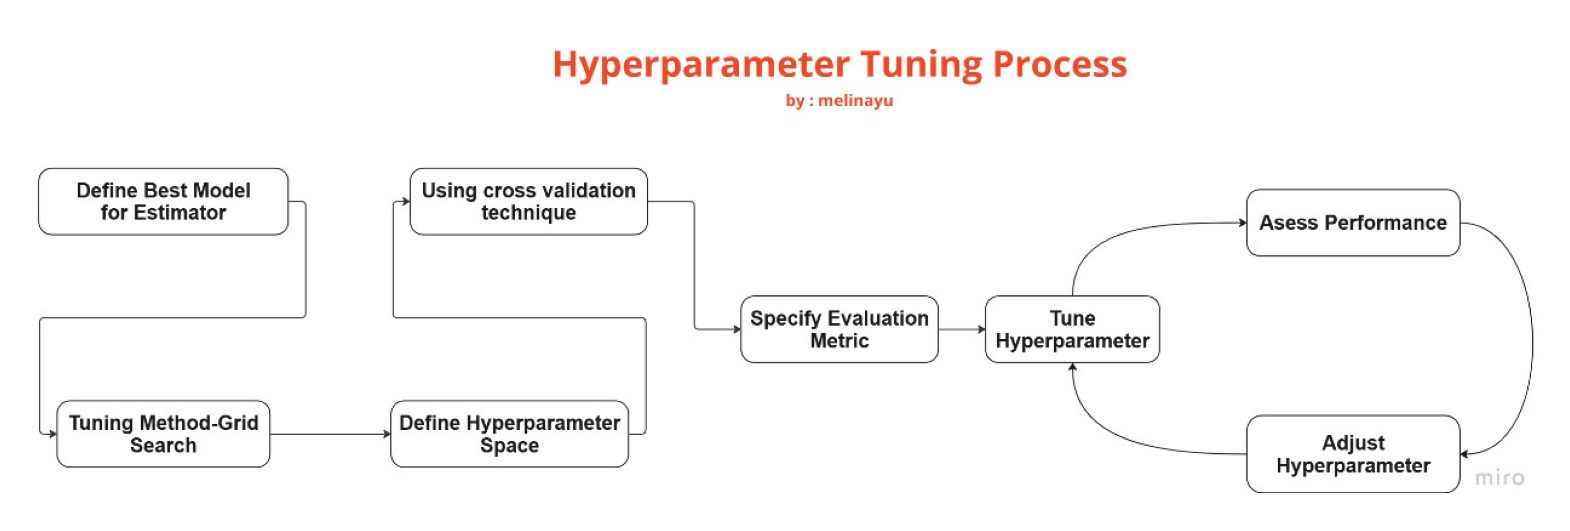

In [155]:
# Load and display an image - Hyperparameter Tuning Process
plt.figure(figsize=(20, 10))
img = mpimg.imread(r'C:\Users\user\OneDrive\Documents\Hotel-Booking-Demand-Project\assets\hyperparameter.jpg')
plt.imshow(img)
plt.axis('off')  
plt.show()

`Hyperparameter tuning` is a crucial process in machine learning as it significantly improves model performance by adjusting parameters suited for a specific dataset and goal. With proper optimization, it helps reduce overfitting or underfitting, enhances the model's generalization ability, and speeds up training time. This process enables models to work more effectively under different conditions and data characteristics, ensuring better predictive accuracy and efficiency.

In [156]:
# Display Best Model
model = pickle.load(open('GBC-withResample-v1-0829.sav', 'rb')) # rb = read binary

In [157]:
model

Pipeline(steps=[('FeatureEngineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling_minmax',
                                                  MinMaxScaler(),
                                                  ['total_of_special_requests']),
                                                 ('encoding_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country'])],
                                   verbose_feature_names_out=False)),
                ('Resampling', SMOTE(random_state=42)),
                ('Classifier', GradientBoostingClassifier(random_state=42))])

In [158]:
# Model Improvement 1 - GBC Model 

# Focus on the most impactful hyperparameters on model performance
hyperparam_space_1 = {
    'Classifier__n_estimators': [100, 300, 500],
    'Classifier__learning_rate': [0.01, 0.05, 0.1],
    'Classifier__max_depth': [3, 5, 7],
    'Classifier__min_samples_split': [2, 5, 10],
    'Classifier__min_samples_leaf': [1, 2, 4],
    'Classifier__subsample': [0.6, 0.8, 1.0],
    'Classifier__max_features': ['sqrt', 'log2', None] 
}

**Here’s a concise explanation for the choice of parameters:**
- `n_estimators`
    - Description: The number of boosting stages to perform.
    - Optimal Range: 100–1000 (start with 100 and increase based on performance).
- `learning_rate`
    - Description: The step size shrinkage used to prevent overfitting. Smaller values often improve performance but require more n_estimators.
    - Optimal Range: 0.01–0.2
- `max_depth` 
    - Description: The maximum depth of the individual decision trees.
    - Optimal Range: 3–10 (start small to avoid overfitting).
- `min_samples_split`
    - Description: The minimum number of samples required to split an internal node.
    - Optimal Range: 2–10
- `min_samples_leaf` 
    - Description: The minimum number of samples required to be in a leaf node.
    - Optimal Range: 1–10
- `subsample` 
    - Description: The fraction of samples used for fitting the individual base learners.
    - Optimal Range: 0.5–1.0
- `max_features` 
    - Description: The number of features to consider when looking for the best split.
    - Optimal Range: "sqrt", "log2", or `None`.

In [159]:
tuning_gbc_1 = GridSearchCV(
    estimator=model, 
    param_grid=hyperparam_space_1,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

In [160]:
tuning_gbc_1.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.01, 0.05, 0.1],
                         'Classifier__max_depth': [3, 5, 7],
                         'Classifier__max_features': ['sqrt', 'log2', None],
                         'Classifier__min_samples_leaf': [1, 2, 4],
                         'Classifier__min_samples_split': [2, 5, 10],
                         'Classifier__n_estimators': [100, 300, 500],
                         'Classifier__subsample': [0.6, 0.8, 1.0]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [161]:
tuning_gbc_1.best_score_

np.float64(0.8352532355398055)

In [162]:
tuning_gbc_1.best_params_

{'Classifier__learning_rate': 0.01,
 'Classifier__max_depth': 5,
 'Classifier__max_features': None,
 'Classifier__min_samples_leaf': 2,
 'Classifier__min_samples_split': 5,
 'Classifier__n_estimators': 500,
 'Classifier__subsample': 0.6}

Best Hyperparameter Gradient Boosting Classifier from Gridsearch result => `learning_rate = 0.01`, `max_depth = 5`, `max_features = None`, `min_samples_leaf = 2`, `min_samples_split = 5`, `n_estimators = 500`, `subsample = 0.6`.

In [163]:
# Model Improvement 2 - GBC Model 

# Focus on the most impactful hyperparameters on model performance
hyperparam_space_2 = {
    'Classifier__n_estimators': [450, 500, 550],
    'Classifier__learning_rate': [0.01, 0.025, 0.001],
    'Classifier__max_depth': [4, 5, 6],
    'Classifier__min_samples_split': [3, 5, 7],
    'Classifier__min_samples_leaf': [2, 3],
    'Classifier__subsample': [0.4, 0.5, 0.6],
    'Classifier__max_features': [None]  
}

Comparing the best parameter values from `Gradient Boosting Classifier` with the nearby values that were not used in the previous improvement to find the best performance.

In [164]:
tuning_gbc_2 = GridSearchCV(
    estimator=model, 
    param_grid=hyperparam_space_2,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

In [165]:
tuning_gbc_2.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('FeatureEngineering',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling_minmax',
                                                                         MinMaxScaler(),
                                                                         ['total_of_special_requests']),
                                                                        ('encoding_ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['market_segment',
                                                                          'deposit_type',
                                                                          'custome...
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.01, 0.025, 0.001],
                         'Classifier__max_depth': [4, 5, 6],
                         'Classifier__max_features': [None],
                         'Classifier__min_samples_leaf': [2, 3],
                         'Classifier__min_samples_split': [3, 5, 7],
                         'Classifier__n_estimators': [450, 500, 550],
                         'Classifier__subsample': [0.4, 0.5, 0.6]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [166]:
tuning_gbc_2.best_score_ 

np.float64(0.8355598788793624)

In [167]:
best_score = tuning_gbc_2.best_score_
print(f"Gradient Boosting Classifier Model after Tunning: {best_score:.2f}")

Gradient Boosting Classifier Model after Tunning: 0.84


In [168]:
tuning_gbc_2.best_params_

{'Classifier__learning_rate': 0.01,
 'Classifier__max_depth': 5,
 'Classifier__max_features': None,
 'Classifier__min_samples_leaf': 2,
 'Classifier__min_samples_split': 3,
 'Classifier__n_estimators': 550,
 'Classifier__subsample': 0.6}

The best model from the second improvement phase is now ready to be evaluated on test data, analyzed for residuals, and monitored throughout the deployment and implementation stages. The tuning has likely enhanced its performance and generalization, making it a strong candidate for these subsequent stages.

In [169]:
# Update best model
best_model = tuning_gbc_2.best_estimator_

**7.5 Analyze Model**

- Evaluate model on data testing

In [170]:
# Classification Report Before Tuning
from sklearn.metrics import classification_report

y_test_score = benchmark_resample.best_estimator_.predict(X_test)
y_test_score_prob = benchmark_resample.best_estimator_.predict_proba(X_test)
y_train_score_prob = benchmark_resample.best_estimator_.predict_proba(X_train)

print("Model Gradient Boosting Classifier (Before Tunning) - on Testing")
print(classification_report(y_test, y_test_score))
print()
print("ROC-AUC Score (Training): ", roc_auc_score(y_train, y_train_score_prob[:,1]))
print("ROC-AUC Score (Test): ", roc_auc_score(y_test, y_test_score_prob[:,1]))

Model Gradient Boosting Classifier (Before Tunning) - on Testing
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1230
           1       0.49      0.66      0.56       383

    accuracy                           0.75      1613
   macro avg       0.68      0.72      0.69      1613
weighted avg       0.79      0.75      0.76      1613


ROC-AUC Score (Training):  0.8457791439742496
ROC-AUC Score (Test):  0.8313231017427667


**Insight:**<br>

Both the training and test ROC-AUC scores are relatively high (greater than 0.8), which indicates that the model has good discriminatory power. It can effectively distinguish between the positive and negative classes.

In [171]:
# Classification Report After Tuning

y_test_score = tuning_gbc_2.best_estimator_.predict(X_test)
y_test_score_prob = tuning_gbc_2.best_estimator_.predict_proba(X_test)
y_train_score_prob = tuning_gbc_2.best_estimator_.predict_proba(X_train)

print("Model Gradient Boosting Classifier (After Tunning) - on Testing")
print(classification_report(y_test, y_test_score))
print()
print("ROC-AUC Score (Training): ", roc_auc_score(y_train, y_train_score_prob[:,1]))
print("ROC-AUC Score (Test): ", roc_auc_score(y_test, y_test_score_prob[:,1]))

Model Gradient Boosting Classifier (After Tunning) - on Testing
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1230
           1       0.50      0.67      0.57       383

    accuracy                           0.76      1613
   macro avg       0.69      0.73      0.70      1613
weighted avg       0.79      0.76      0.77      1613


ROC-AUC Score (Training):  0.8671797212852878
ROC-AUC Score (Test):  0.8346876393045916


**Insight:**<br>

**Improved Test ROC-AUC**: The **test ROC-AUC** score increased from **0.831** to **0.834**, indicating a slight but positive improvement in the model’s ability to distinguish between canceled and non-canceled bookings on unseen data after tuning. This suggests that the tuning process has helped the model make better predictions on the test set.

- Residual Analysis

In [172]:
best_model = tuning_gbc_2.best_estimator_

In [173]:
y_score_prob = tuning_gbc_2.predict_proba(X_test)
y_score_prob = y_score_prob[:, 1]

y_score = tuning_gbc_2.predict(X_test)

In [174]:
y_score_prob

array([0.83750018, 0.50977029, 0.22256184, ..., 0.60072109, 0.03049587,
       0.05493298])

In [175]:
y_score

array([1, 1, 0, ..., 1, 0, 0])

- Learning Curve Inspection

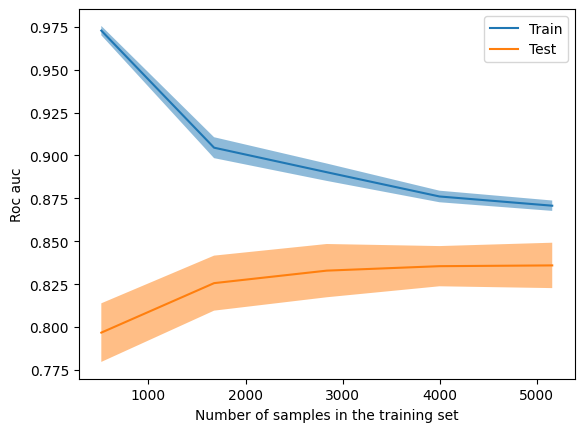

In [176]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(best_model, X_train, y_train, scoring='roc_auc')

- ***Training Curve:*** The ROC-AUC values ​​on the training data tend to decrease as the number of samples increases. This indicates that the model becomes more complex as it is trained with more data, potentially memorizing the training data.
- ***Testing Curve:*** The ROC-AUC values ​​on the testing data tend to increase up to a certain point, then plateau. This indicates that the model initially learns more general features, and after reaching saturation, additional training data does not provide significant performance improvements on previously unseen data.
- ***Shaded Area:*** **The shaded area represents the uncertainty or variability in the ROC-AUC estimates. The narrower the area, the more consistent the results.**

**7.6 Model Calibration**

The plot shows the calibration of machine learning model. In essence, it assesses how well the predicted probabilities from model align with the actual observed frequencies of the positive class.<br>

- **Key Elements of the Plot:**
    - X-axis: Represents the mean predicted probability of the positive class.
    - Y-axis: Represents the fraction of positives observed in the data for a given predicted probability bin.

- **Perfect Calibration:**<br>
The black dotted line represents perfect calibration. This line indicates that if the model predicts a probability of 0.5 for the positive class, then exactly 50% of the instances in that predicted probability bin should actually belong to the positive class.

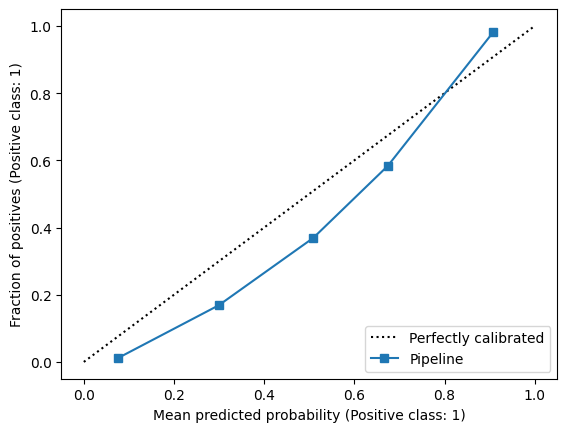

In [177]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

CalibrationDisplay.from_estimator(best_model, X_train, y_train)

**Insight:**<br>

The first plot shows the best model calibration before recalibration. The blue line deviating from the black dotted line (representing a perfect model) indicates the model is not perfect at predicting the probability of the positive class. It’s possible that the model is:<br>

- Overconfident: The model is too confident in its predictions, so the probabilities given are either too high or too low compared to the actual frequency of the positive class.

- Unconfident: The model is too uncertain about its predictions, so the probabilities given tend to be somewhere in the middle.

In [178]:
clf_calibrated = CalibratedClassifierCV(best_model, cv='prefit')

In [179]:
clf_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('FeatureEngineering',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('scaling_minmax',
                                                                                   MinMaxScaler(),
                                                                                   ['total_of_special_requests']),
                                                                                  ('encoding_ohe',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 handle_unknown='ignore'),
                                                                                   ['market_segment',
                                                                                    'deposit_type',
                                                                                    'customer_type',
                                                                                    'reserved_room_type']),
                                                                                  ('binary',
                                                                                   BinaryEncoder(),
                                                                                   ['country'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('Resampling',
                                                  SMOTE(random_state=42)),
                                                 ('Classifier',
                                                  GradientBoostingClassifier(learning_rate=0.01,
                                                                             max_depth=5,
                                                                             min_samples_leaf=2,
                                                                             min_samples_split=3,
                                                                             n_estimators=550,
                                                                             random_state=42,
                                                                             subsample=0.6))]))

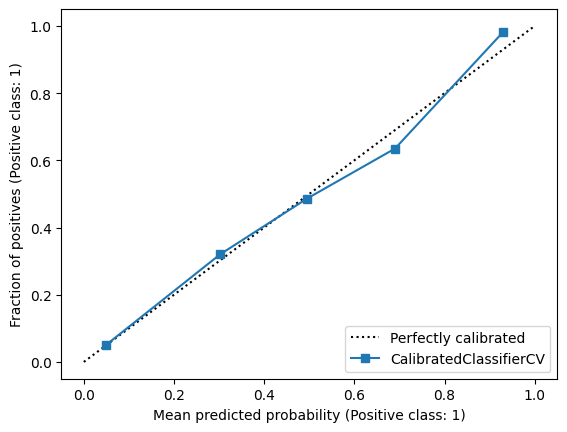

In [180]:
# Classifier after calibration
CalibrationDisplay.from_estimator(clf_calibrated, X_train, y_train)

**Insight:**<br>

Meanwhile, the second plot shows the model calibration after recalibration using CalibratedClassifierCV. The blue line in **this plot to be closer to the black dotted line**, indicating that **the model has been calibrated so that the given probabilities are more in line with the actual frequency of the positive class**.

Confusion Matrix:
[[970 260]
 [127 256]]


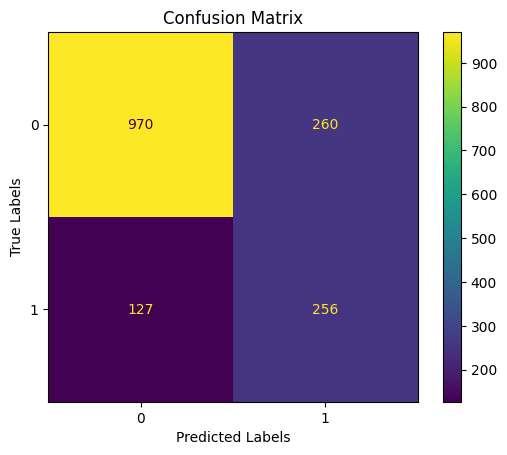

In [181]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Membuat confusion matrix
cm = confusion_matrix(y_test, y_score)

# Menampilkan confusion matrix di terminal
print("Confusion Matrix:")
print(cm)

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='viridis')  
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()

**7.7 Model Explanation and Interpretation**

- Feature Importance (Tree Based Model) -> Gradient Boosting Classifier Model

In [182]:
final_model = clf_calibrated.estimator.named_steps['Classifier'] # Get the model
preprocessing = clf_calibrated.estimator.named_steps['FeatureEngineering'] # Get preprocessor

In [183]:
feature_name = preprocessing.get_feature_names_out()
score = final_model.feature_importances_

In [184]:
feat_imp = pd.DataFrame({
    'feature': feature_name,
    'importance': score
}).sort_values('importance', ascending=False)

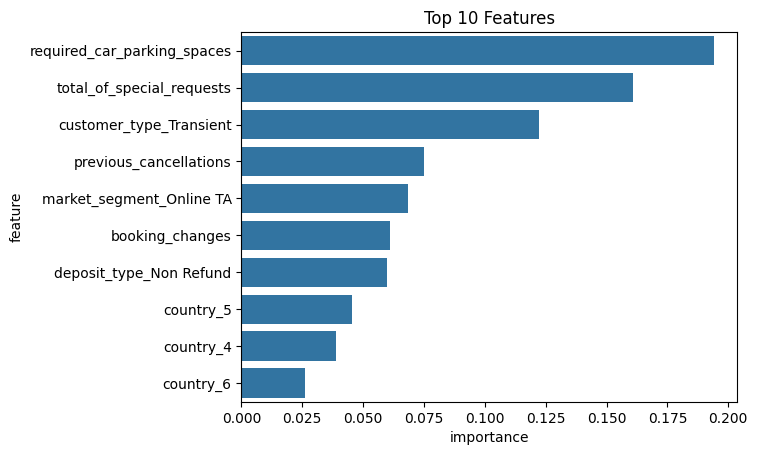

In [185]:
result = pd.DataFrame({'feature': feature_name, 'importance': score}).sort_values('importance', ascending=False).head(10)
sns.barplot(result, x='importance', y='feature')
plt.title("Top 10 Features")
plt.show()

**Insight:**<br>

`Feature Importance:` The chart visually ranks the top 10 features by their importance in a machine learning model. Features with higher importance scores have a greater influence on the model's predictions.

- **required_car_parking_spaces** appears to be the most important feature, suggesting that the need for car parking significantly impacts the model's predictions.
- **total_of_special_requests** also has high importance, indicating that the number of special requests made by guests is a strong predictor.
- **customer_type_Transient** being a significant feature suggests that transient guests (those staying for a short duration) exhibit different behaviors or characteristics that influence the model's predictions.
- Cancellation History: **previous_cancellations** is a notable feature, implying that guests with a history of cancellations might be associated with certain outcomes or behaviors that the model is trying to predict.

- SHAP Value identification

In [186]:
import shap

In [187]:
shap.initjs()

In [188]:
model = clf_calibrated.estimator.named_steps['Classifier']
preprocessor = clf_calibrated.estimator.named_steps['FeatureEngineering']

X_train_pre = preprocessor.transform(X_train)
X_train_pre_df = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())

X_test_pre = preprocessor.transform(X_test)
X_test_pre_df = pd.DataFrame(X_test_pre, columns=preprocessor.get_feature_names_out())

In [189]:
explainer = shap.TreeExplainer(model=model,
                                 data=X_train_pre_df,
                                 model_output="probability",
                                 feature_names=preprocessor.get_feature_names_out())

In [190]:
shap_values = explainer.shap_values(X_train_pre)

 99%|===================| 6373/6448 [01:24<00:00]        

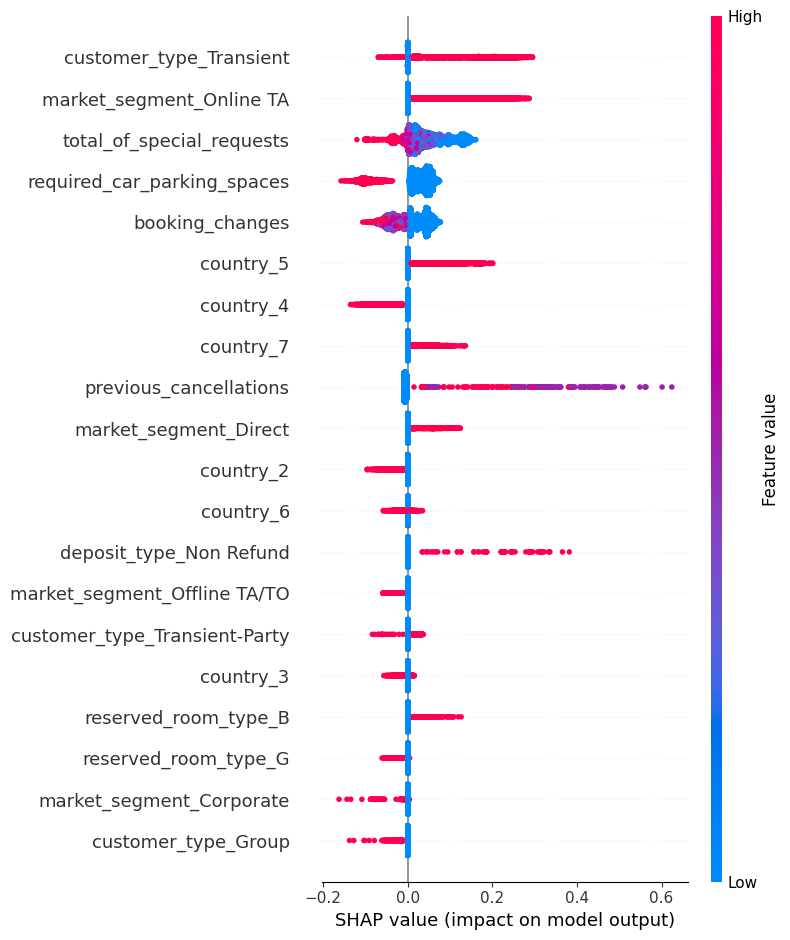

In [191]:
shap.summary_plot(shap_values, X_train_pre, feature_names=preprocessor.get_feature_names_out())

**Insight:**<br>

- total_of_special_requests, booking_changes, and required_car_parking_spaces have a very large impact on the prediction. The dots on these features tend to be red, indicating that increasing the value of these features will increase the prediction value.
- Country-related features (country_5, country_4, country_7, etc.) also have a significant impact. This indicates that the country of origin of the customer has a strong influence on the behavior or characteristics being predicted.
- Customer type and market segment-related features such as customer_type_Transient, market_segment_Online TA, and market_segment_Direct also make a significant contribution. This indicates that the type of customer and how they make reservations have an impact on the prediction results.

## **Section 8. Model Deployment**

In [195]:
best_model.fit(feature, target)
pickle.dump(best_model, open("GBC-final-clfCalibrated-0835.sav", 'wb'))

In [206]:
# concatenate data-train
train_data = pd.concat([X_train, y_train], axis=1)

In [210]:
# concatenate data-test
test_data = pd.concat([X_test, y_test], axis=1)

In [209]:
# save the data-train
train_data.to_csv('data-train.csv')

In [211]:
# save the data-test
test_data.to_csv('data-test.csv')

## **Section 9. Model Implementation**

**9.1 How to implement the model ?**


**9.2 What are the limitations of the model ?**

**9.3 Business Calculation (Simulation using unseen data)**

In [202]:
X_unseen = df_unseen.drop('is_canceled', axis=1)
y_unseen = df_unseen['is_canceled']

In [203]:
# binning data unseen

df_unseen['previous_cancellations'] = df_unseen['previous_cancellations'].apply(lambda x: 0 if x == 0 else 1)
df_unseen['booking_changes'] = df_unseen['booking_changes'].apply(lambda x: 0 if x == 0 else 1)
df_unseen['days_in_waiting_list'] = df_unseen['days_in_waiting_list'].apply(lambda x: 0 if x == 0 else 1)
df_unseen['required_car_parking_spaces'] = df_unseen['required_car_parking_spaces'].apply(lambda x: 0 if x == 0 else 1)

## **Section 10. Conclusion and Recommendation**

**10.1 Conclusion**
- Conclusion (Model)
- Conclusion (Business)

**10.2 Recommendation**
- Recommendation (Model)
- Recommendation (Business)